In [6]:
import pandas
import numpy
import matplotlib.pyplot as pyplot

data = pandas.read_csv("data/Lyke2020.csv")

# Filters out any rows that are not quasars
# Should filter out very few rows
data = data[
    (data['IS_QSO_FINAL'] == 1)
]

In [7]:
# Drops rows with uncertain (anything between 0 and 1) BAL_PROB
data = data[
    (data['BAL_PROB'] == 1) | (data['BAL_PROB'] == 0)
]

# Changes BAL_PROB values from 0s and 1s to strings 'Non-BAL' and 'BAL', respectively
data['BAL_PROB'] = data['BAL_PROB'].replace({0: 'Non-BAL', 1: 'BAL'})

In [8]:
# List of flux columns to be used
cols = [
            'Z',
            'BAL_PROB',
            'PSFFLUX_0', 'PSFFLUX_1', 'PSFFLUX_2', 'PSFFLUX_3', 'PSFFLUX_4',
            'FUV', 'NUV',
            'YFLUX', 'JFLUX', 'HFLUX', 'KFLUX',
            'W1_FLUX', 'W2_FLUX',
            'FIRST_FLUX',
            'XMM_SOFT_FLUX', 'XMM_HARD_FLUX',
            'GAIA_PARALLAX',
            'GAIA_G_FLUX_SNR', 'GAIA_BP_FLUX_SNR', 'GAIA_RP_FLUX_SNR',
            'W1_FLUX_SNR', 'W2_FLUX_SNR'
        ]

flux_cols = [
            'PSFFLUX_0', 'PSFFLUX_1', 'PSFFLUX_2', 'PSFFLUX_3', 'PSFFLUX_4',
            'FUV', 'NUV',
            'YFLUX', 'JFLUX', 'HFLUX', 'KFLUX',
            'W1_FLUX', 'W2_FLUX',
            'FIRST_FLUX',
            'XMM_SOFT_FLUX', 'XMM_HARD_FLUX',
            'GAIA_PARALLAX',
            'GAIA_G_FLUX_SNR', 'GAIA_BP_FLUX_SNR', 'GAIA_RP_FLUX_SNR'
            ]

# Keeps the specified columns
data = data[cols]

# REMOVES OUTLIERS FROM ALL SPECIFIED FLUX COLUMNS
# This is required, since some columns have significant outliers (ex. -9999)
for col in flux_cols:
    # Calculates IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Defines lower and upper bounds to filter out outliers
    lower_bound = Q1 - 7.5 * IQR
    upper_bound = Q3 + 7.5 * IQR

    # Filters the data to replace outliers with NaN
    data[col] = numpy.where((data[col] < lower_bound) | (data[col] > upper_bound), numpy.nan, data[col])

In [9]:
print(data[['W1_FLUX_SNR', 'W2_FLUX_SNR']].describe())

         W1_FLUX_SNR    W2_FLUX_SNR
count  336523.000000  336523.000000
mean       14.067074      10.815853
std        23.392317      17.543424
min     -5563.419400   -1546.366800
25%         5.220209       3.691312
50%         9.232779       6.770744
75%        16.565929      12.550280
max      2352.076000    4437.058000


In [10]:
# Filters for high signal-to-noise ratio
W1_threshold = 9.23
W2_threshold = 6.77

data = data[(data['W1_FLUX_SNR'] > W1_threshold) & (data['W2_FLUX_SNR'] > W2_threshold)]

In [11]:
# Constants
c = 300000  # Speed of light in km/s
H0 = 70    # Hubble constant in km/s/Mpc

# Calculates distance in Mpc with Hubble's Law
data['Distance_Mpc'] = (c * data['Z']) / H0  

# Creates new _LUMINOSITY columns for each flux column
for col in flux_cols:
    data[f'{col}_LUMINOSITY'] = 4 * numpy.pi * (data['Distance_Mpc']**2) * data[col]

In [12]:
#Saves the updated data to a new CSV file
data.to_csv('data/Clean_Quasar_Data_High_SNR.csv', index=False)

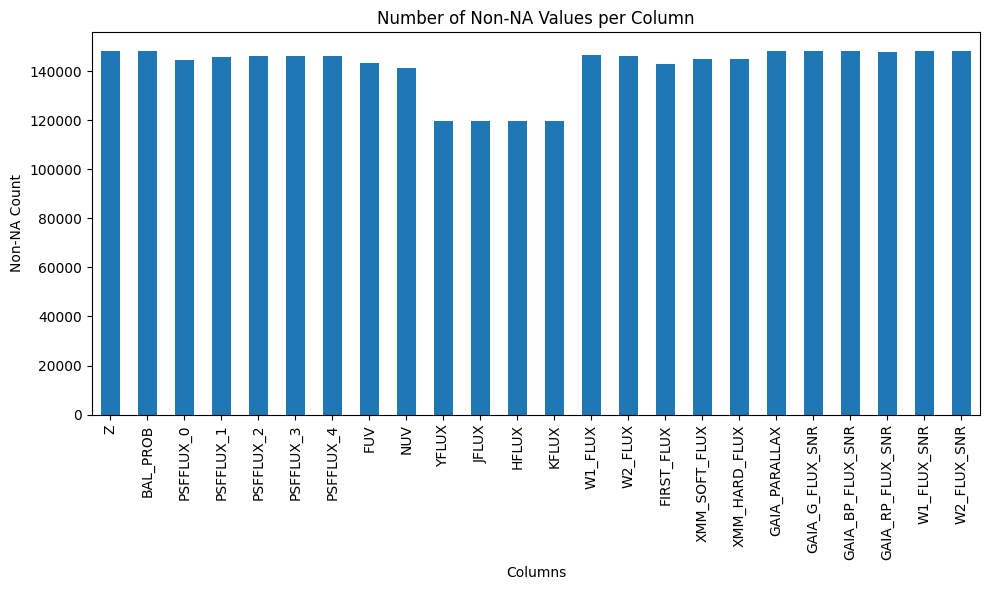

In [13]:
filter = data[cols]

non_na_counts = filter.notna().sum()

pyplot.figure(figsize=(10, 6))
non_na_counts.plot(kind='bar')
pyplot.title('Number of Non-NA Values per Column')
pyplot.xlabel('Columns')
pyplot.ylabel('Non-NA Count')
pyplot.xticks(rotation=90)
pyplot.tight_layout()
pyplot.show()